## TBC Analystics Test (Beer Advocate)

**From [How to Hire and Test for Data Skills: a One-Size-Fits-All Interview Kit](https://tcbanalytics.com/2016/01/29/how-to-hire-and-test-for-data-skills-a-one-size-fits-all-interview-kit/)**

"In an effort to make the interviewing experience a bit more fun, we use a dataset that involves beer. This dataset consists of 1.5 million beer reviews from Beer Advocate. It is an ideal dataset for testing candidates since it is too large to fit into Excel, but small enough to process on a single laptop in Python or R. We prefer that candidates complete the test in either Python or R, and generally if they are hesitant about using or trying to learn either of these languages, that should signal a red flag.

- Which brewery produces the strongest beers by ABV%?

- If you had to pick 3 beers to recommend using only this data, which would you pick?

- Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?

- Lastly, if I typically enjoy a beer due to its aroma and appearance, which beer style should I try?"

Here's my attempt. Note that from the url, the data may take a while to load.


In [6]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
url = "https://s3.us-west-1.amazonaws.com/tanyacashorali.com/beer_reviews.csv"
df = pd.read_csv(url); #print(df)

tmp = df['brewery_id'].unique(); print(len(tmp)) # 5840 BREWERIES
tmp = df['beer_beerid'].unique(); print(len(tmp)) # 66055 BEERS

5840
66055


In [9]:
# A COUPLE OF FUNCTIONS I'LL USE 
def GROUP_AGG(data,field,sum_field,action):
    astring = 'data.groupby(field).%s(numeric_only=True)' %(action)
    return eval(astring)

def JOIN(table1,table2,on,how):
    return pd.merge(table1,table2,on = [on], how = how)

def GROUP_COUNT(data,field):
    return data.groupby(field).agg(Count=(field,'count')).reset_index()

### Which brewery produces the strongest beers by ABV%?
**Doing for both maximum ABV beers and highest brewery average ABV**

In [11]:
def ABV(action):
    ave1 = GROUP_AGG(df,'brewery_id','beer_abv',action);
    ave1['brewer_id'] = ave1.index
    ave1 = ave1[['brewer_id']]

    ave2 = GROUP_AGG(df,'brewery_name','beer_abv',action);
    ave2 = ave2.rename(columns={'brewery_id':'brewer_id'})
    ave2['brewer_name'] = ave2.index
    ave2 = ave2[['brewer_id','brewer_name','beer_abv']]

    return JOIN(ave1,ave2,'brewer_id', 'left')

**By maximum ABV**

In [13]:
maxb = ABV('max')
maxb = maxb.sort_values(by=['beer_abv'],ascending=False); maxb.head(10)

,brewer_id,brewer_name,beer_abv
2503,6513,Schorschbräu,57.70
4201,16315,BrewDog,41.00
4006,15237,De Struise Brouwers,39.00
137,173,Hair of the Dog Brewing Company / Brewery and ...,29.00
28,35,Boston Beer Company (Samuel Adams),27.00
4285,16594,LagerHaus Grill & Brewery,22.00
1210,1924,DuClaw Brewing Company,21.92
2075,4738,Grand Lake Brewing Company,20.00
3024,9629,Short's Brewing Company,20.00
3750,13564,Sonoran Brewing Company,19.50


**By average ABV**

In [496]:
ave = ABV('mean')
ave = ave.sort_values(by=['beer_abv'],ascending=False); ave.head(10)

,brewer_id,brewer_name,beer_abv
2503,6513,Schorschbräu,19.228824
3826,14060,Shoes Brewery,15.200000
1537,2873,Rome Brewing Company,13.840000
598,736,Hurlimann Brewery,13.750000
3117,10038,Alt-Oberurseler Brauhaus,13.200000
4950,21755,Rascal Creek Brewing Co.,13.000000
5325,24215,Monks Porter House,12.466667
29,36,Brasserie Grain d' Orge (Brasserie Jeanne d'Ar...,12.445860
1725,3452,Tugboat Brewing Company,12.187500
471,593,Morgan Street Brewery,12.000000


### If you had to pick 3 beers to recommend using only this data, which would you pick?

**As noted in *[the exercise](https://tcbanalytics.com/2016/01/29/how-to-hire-and-test-for-data-skills-a-one-size-fits-all-interview-kit/)*, this is open to interpretation, so I've chosen to rank the beers by the overall review and the mean of the other reviews (aroma, appearance, palate and taste).** 

**Since there is a large variation in the number of reviews, I've applied a confidence interval around the mean score and sorted by the bottom end of this. Since using the *z*-score, the minimum number of reviews is 30, although fewer may be condsidered by applying the *t*-score (see code [here](https://github.com/steviecurran/one-sample)).**

**I have also added an option to do this for individual beer styles (104 in total). This can also be done for ABV ranges, but ABV is oftern correlated with the style**

In [14]:
import ipywidgets as widgets
from ipywidgets import *
style = {'description_width': 'initial'}

conf = widgets.FloatSlider(
    value=95, min=80, max=99.9,step=0.1, 
    description='Confidence level for beer rating [%]:', 
    #disabled=False, continuous_update=False, 
    orientation='horizontal', readout=True, 
    readout_format='.1f', style = style,
    layout=Layout(width='70%', height='80px')
)
conf # DOESN'T CHANGE RANKING, JUST CONFIDENCE RANGE

FloatSlider(value=95.0, description='Confidence level for beer rating [%]:', layout=Layout(height='80px', widt…

In [15]:
df['review_others'] = (df['review_aroma']+df['review_appearance']+df['review_palate']+df['review_taste'])/4
# MEAN OF OTHER NON-review_overall REVIEWS

In [16]:
styles = df['beer_style'].unique(); styles = sorted(styles); styles.insert(0, 'All')
style = widgets.Dropdown(options=styles,value='All', description='Beer style:',disabled=False)
style

Dropdown(description='Beer style:', options=('All', 'Altbier', 'American Adjunct Lager', 'American Amber / Red…

In [17]:
revs = ['review_overall', 'review_aroma','review_appearance','review_palate', 'review_taste','review_others']
prior1 = widgets.Dropdown(options=revs,value='review_overall',description='Character:',disabled=False)
prior1

Dropdown(description='Character:', options=('review_overall', 'review_aroma', 'review_appearance', 'review_pal…

In [18]:
#revs2 = revs.remove(prior1.value) # JUPYTER QUITE FLAKY WITH THIS
prior2 = widgets.Dropdown(options=revs,value='review_others',description='Character:',disabled=False)
prior2 

Dropdown(description='Character:', index=5, options=('review_overall', 'review_aroma', 'review_appearance', 'r…

In [19]:
revs = ['review_overall', 'review_aroma','review_appearance','review_palate',
        'review_taste','review_others']

def comp(action):
    tmp = GROUP_AGG(df,'beer_beerid','review_overall',action); 
    tmp['beer_id'] = tmp.index
    tmp = tmp[['beer_id','review_overall', 'review_aroma', 'review_appearance',
               'review_palate', 'review_taste','review_others']]
    for (i,rev) in enumerate(revs):
        rev_new = '%s_%s' %(rev,action)
        tmp = tmp.rename(columns={rev:rev_new})
    return tmp

aves = comp('mean'); #print(aves)
SDs = comp('std'); #print(SDs)
counts = GROUP_COUNT(df,'beer_beerid')
counts = counts.rename(columns={'beer_beerid':'beer_id'})
tmp = JOIN(aves,SDs,'beer_beerid', 'left'); #print(tmp)
tmp = tmp.rename(columns={'beer_id_x':'beer_id'})

tmp = tmp[['beer_id','review_overall_mean','review_overall_std',
               'review_others_mean','review_others_std',
               'review_aroma_mean','review_aroma_std',
               'review_appearance_mean','review_appearance_std',
               'review_palate_mean','review_palate_std',
               'review_taste_mean', 'review_taste_std']]
tmp2 = JOIN(tmp,counts,'beer_id', 'left'); #print(tmp2)
tmp3 = df.groupby('beer_beerid').first()
tmp3['beer_id'] =  tmp3.index
tmp3 = tmp3[['beer_id', 'beer_name','beer_style','beer_abv','brewery_id', 'brewery_name',]]
beers = JOIN(tmp3,tmp2,'beer_id', 'left');

beers = beers[beers['Count'] > 30] # 30 FOR Z-VALUE
beers['Count'] = beers['Count'].astype(float)

for (i,rev) in enumerate(revs):
    SD = "%s_std" %(rev)
    beers[SD] = beers[SD] * (beers['Count']/(beers['Count']-1))**0.5 # SAMPLE
    beers[SD] = beers[SD]/(beers['Count']**0.5) # NOW STANDARD ERROR
    #print(beers[SD].describe()) # GET SOME ZEROES FROM MEANS BEING EQUAL WHEN NUMBERS ARE LOW
    beers.loc[beers[SD] == 0, SD] = np.nan
    
from scipy.stats import norm
con = conf.value # 95 # 95% confidence just now
p = 1-con/100
Z = norm.ppf(1-p/2,loc=0,scale=1)

def choice(style,prior1,prior2):
    if style == "All":
        data = beers
    else:
        data = beers[beers['beer_style'] == style]
    
    for (i,rev) in enumerate(revs):
        SD = "%s_std" %(rev)
        ave = "%s_mean" %(rev)
        low = '%s_low' %(rev)
        high = '%s_high' %(rev)
        delta = '+/- %s' %(rev)
        new = "%s" %(rev) 
        CI = Z*data[SD]
        data[delta] = CI
        data[low] = data[ave] - CI
        data[high] = data[ave] + CI
        data = data.rename(columns={ave:new})
        del data[SD]

    data = data[['beer_id', 'beer_name', 'beer_style', 'beer_abv', 'brewery_id', 'brewery_name',
                   'review_overall','+/- review_overall', 'review_overall_low','review_overall_high',
                   'review_others','+/- review_others','review_others_low','review_others_high',
                   'review_aroma','+/- review_aroma', 'review_aroma_low', 'review_aroma_high', 
                   'review_appearance','+/- review_appearance','review_appearance_low', 'review_appearance_high', 
                   'review_palate','+/- review_palate', 'review_palate_low','review_palate_high', 
                   'review_taste','+/- review_taste', 'review_taste_low', 'review_taste_high',
                   'Count']]
   
    data['Count'] = data['Count'].astype(int)      
    data = data.rename(columns={'Count':'No. reviews'})
    
    p1 = "%s_low" %(prior1); p2 = "%s_low" %(prior2);
    ep1 = "+/- %s" %(prior1); ep2 =  "+/- %s" %(prior2);
    
    top = data.sort_values(by=[p1,p2],ascending=False);
    top = top[['beer_id', 'beer_name', 'beer_style', 'beer_abv', 'brewery_id', 
               'brewery_name', prior1,ep1,prior2,ep2,'No. reviews']]
    
    print("\n  --- BEST THREE BEERS OF '%s' ACCORDING TO THE LOWEST MEAN SCORES OF ---" %(style))
    print("                         %s AND %s\n"            %(prior1,prior2))
    print(top.head(3))
    print("\nREVIEWS ARE OUT OF 5 AND THE +/- VALUES ARE FOR A %1.1f%% CONFIDENCE INTERVAL" %(con))
choice(style.value,prior1.value,prior2.value)


  --- BEST THREE BEERS OF 'All' ACCORDING TO THE LOWEST MEAN SCORES OF ---
                         review_overall AND review_others

       beer_id                    beer_name                        beer_style  \
53419    63649                  Rare D.O.S.  American Double / Imperial Stout   
37035    44910                  Dirty Horse                Lambic - Unblended   
7188      8626  Southampton Berliner Weisse                Berliner Weissbier   

       beer_abv  brewery_id                             brewery_name  \
53419       NaN       22147  Peg's Cantina & Brewpub / Cycle Brewing   
37035       7.0       15237                      De Struise Brouwers   
7188        2.0        1628                Southampton Publick House   

       review_overall  +/- review_overall  review_others  +/- review_others  \
53419        4.848485            0.091719       4.719697           0.073459   
37035        4.820513            0.092892       4.589744           0.081014   
7188         4

**According to their overall review score and the mean of the other scores, of all the beers, *Rare D.O.S., Dirty Horse* and  *Southampton Berliner Weisse* are the best three** 

## Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?

**The raw reviews are quantised in increments of 0.5, so will use the mean ratings above for scatter plots**

For Review aroma, Kendall's tau gives a p-value = 0.00e+00
For Review apperance, Kendall's tau gives a p-value = 0.00e+00
For Review palette, Kendall's tau gives a p-value = 0.00e+00
For Review taste, Kendall's tau gives a p-value = 0.00e+00


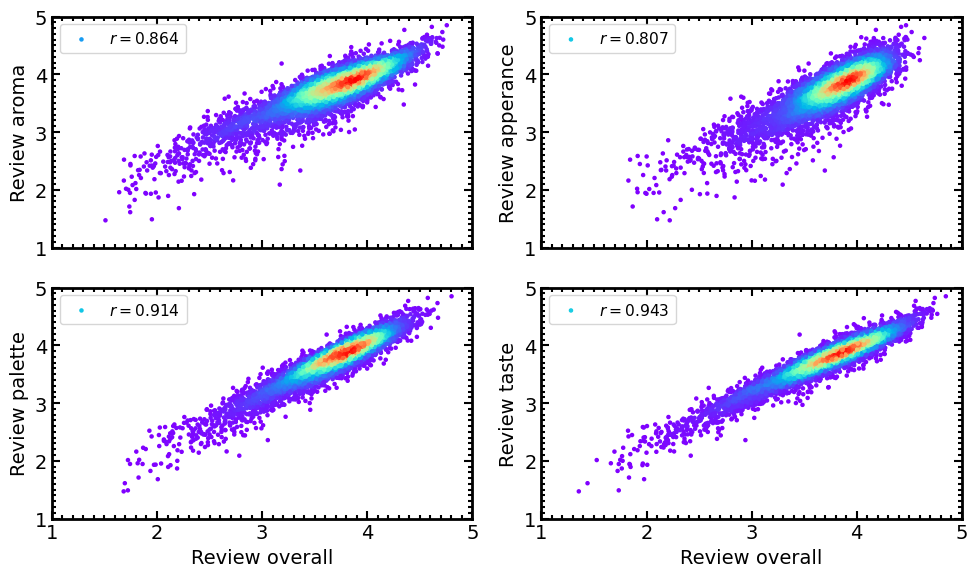

In [20]:
data = beers

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde  
from matplotlib import cm
from scipy.stats import binned_statistic_2d

plt.rcParams.update(plt.rcParamsDefault) # STOP seaborn TAKING OVER

font = 14
plt.rcParams.update({'font.size': font})
fig, axs = plt.subplots(2, 2, figsize=(10,6))

def spines(ax):
    plt.setp(ax.spines.values(), linewidth=2)
    ax.tick_params(direction='in', length=6, width=1.5, which='major',right=True, top = True)
    ax.tick_params(direction='in', length=3, width=1.5, which='minor',right=True, top = True)
    y = data['review_overall_mean']

y = data['review_overall_mean'].dropna()

x1 = 1; x2 = 5; y1= 1; y2 = 5
cmap = plt.cm.rainbow

def plot(ax,para,ylabel):
    spines(ax)
    x = data[para].dropna()
    r2 = r2_score(x,y)
    xy = np.vstack([x,y]); z = gaussian_kde(xy)(xy);
    ax.scatter(x,y,c=z, s=5, cmap = cmap, label = "$r = %1.3f$" %(np.sqrt(r2)))
    tau, p_value = stats.kendalltau(x, y);
    print("For %s, Kendall's tau gives a p-value = %1.2e" %(ylabel, p_value))
    if (ax == axs[0,0]) | (ax == axs[0,1]):
        ax.axes.xaxis.set_ticklabels([])
    else:
        ax.set_xlabel("Review overall")
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.set_xlim([x1,x2]);ax.set_ylim([y1,y2])
    ax.legend(fontsize = 0.8*font,loc='upper left',scatterpoints=1)

plot(axs[0,0],'review_aroma_mean', "Review aroma")
plot(axs[0,1],'review_appearance_mean', "Review apperance")
plot(axs[1,0],'review_palate_mean',"Review palette")
plot(axs[1,1],'review_taste_mean',"Review taste")

plt.tight_layout()
plt.show()

**All distributions have p-values too small to be measured, but going by the regression coefficient, perhaps not surprisingly, taste is the most important factor.**

**This is confirmed in the following heatmap of the correlations between the reviews from the raw scores. We also see that the ABV of the beer is not a strong contributor to the quality.**

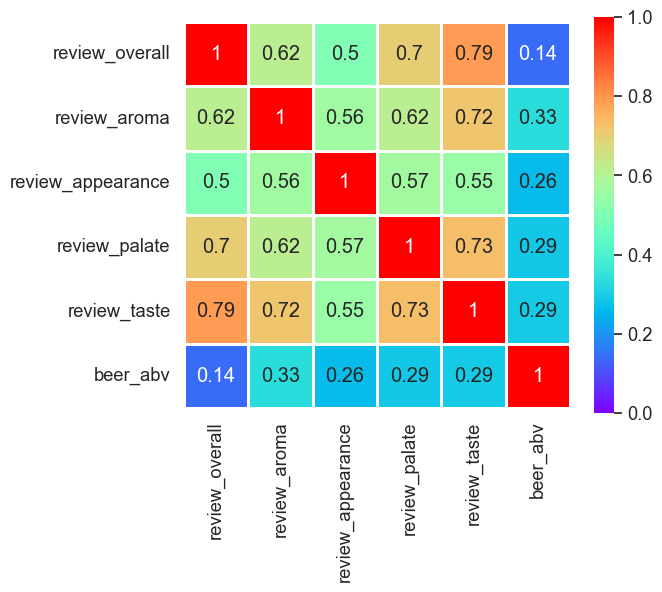

In [21]:
import seaborn as sns
data = df[['review_overall', 'review_aroma', 'review_appearance',
              'review_palate', 'review_taste','beer_abv']]
corr = data.corr(); 
sns.set(font_scale=1.2)
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = False 
f, ax = plt.subplots(figsize = (7, 7)) 
sns.heatmap(corr, annot = True, cmap = cmap, vmin = 0, vmax = 1, 
            mask = mask,square = True, linewidths = 1, ax = ax, cbar_kws={"shrink": .74})

plt.tight_layout()
plt.show()

## Lastly, if I typically enjoy a beer due to its aroma and appearance, which beer style should I try?

**Knock yourself out!**

In [22]:
styles = df['beer_style'].unique(); styles = sorted(styles); styles.insert(0, 'All')
style = widgets.Dropdown(options=styles,value='All', description='Beer style:',disabled=False)
style

Dropdown(description='Beer style:', options=('All', 'Altbier', 'American Adjunct Lager', 'American Amber / Red…

In [27]:
revs = ['review_overall', 'review_aroma','review_appearance','review_palate', 'review_taste','review_others']
prior1 = widgets.Dropdown(options=revs,value='review_aroma', description='Character:',disabled=False)
prior1

Dropdown(description='Character:', index=1, options=('review_overall', 'review_aroma', 'review_appearance', 'r…

In [28]:
#revs2 = revs.remove(prior1.value)
prior2 = widgets.Dropdown(options=revs,value='review_appearance',description='Character:',disabled=False)
prior2 

Dropdown(description='Character:', index=2, options=('review_overall', 'review_aroma', 'review_appearance', 'r…

In [29]:
choice(style.value,prior1.value,prior2.value)


  --- BEST THREE BEERS OF 'Scotch Ale / Wee Heavy' ACCORDING TO THE LOWEST MEAN SCORES OF ---
                         review_aroma AND review_appearance

       beer_id                            beer_name              beer_style  \
23962    29708     AleSmith Wee Heavy - Barrel Aged  Scotch Ale / Wee Heavy   
32239    39619  Berkshire Bourbon Barrel Scotch Ale  Scotch Ale / Wee Heavy   
28369    35036           Founders Backwoods Bastard  Scotch Ale / Wee Heavy   

       beer_abv  brewery_id                    brewery_name  review_aroma  \
23962       9.5         396        AleSmith Brewing Company      4.427711   
32239       9.2          33  Berkshire Brewing Company Inc.      4.310811   
28369      10.2        1199        Founders Brewing Company      4.207353   

       +/- review_aroma  review_appearance  +/- review_appearance  No. reviews  
23962          0.094303           3.951807               0.095030           83  
32239          0.080727           4.108108              

**Issues**
 - Would like widgets to work via functions, but Jupyter doesn't like this
 - prior2 dropdown can be quite flaky about removing the prior1 choice from the list

**Further Work**
 - Clustering to see if reviewers are biased towards a particular style, etc.
 - Rank beers by style, ABV, etc.